# A combination of Recent Optimization-based Attacks

This set of hyperparameters is a variation of the original Inverting Gradients hyperparameter set, including a few changes such as a small deep inversion prior (as in "See Through Gradients"), cosine decay of the step sizes and warmup (also "See Through Gradients"), feature regularization for the last linear layer in the style of some analytic inversion papers, and the structured initialization scheme of "A Framework for Evaluating Gradient Leakage Attacks in Federated Learning".

Minor changes also include a sane color total variation regularization (via double-oppponents TV) and a "soft" signed gradient descent schedule.

Paper URLs: 
* https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html
* https://openaccess.thecvf.com/content/CVPR2021/html/Yin_See_Through_Gradients_Image_Batch_Recovery_via_GradInversion_CVPR_2021_paper.html
* https://arxiv.org/abs/2004.10397
* https://link.springer.com/chapter/10.1007/978-3-319-46475-6_40

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["attack=modern"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=1), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition="unique-class"
cfg.case.user.user_idx = 24
cfg.case.model='resnet18'

cfg.attack.regularization.deep_inversion.scale=1e-4

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      76:1 for target shape [1, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 1

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 24
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.1. p=2 q=0.5. Color TV: double oppponents
      

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [5]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update in model mode: eval.


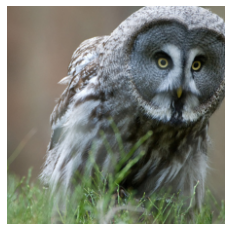

In [6]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [7]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [24] through strategy bias-corrected.
| It: 1 | Rec. loss: 1.4536 |  Task loss: 7.2426 | T: 0.30s
| It: 1001 | Rec. loss: 0.3935 |  Task loss: 0.0002 | T: 161.33s
| It: 2001 | Rec. loss: 0.4014 |  Task loss: 0.0001 | T: 158.85s
| It: 3001 | Rec. loss: 0.3264 |  Task loss: 0.0003 | T: 156.15s
| It: 4001 | Rec. loss: 0.3190 |  Task loss: 0.0002 | T: 157.34s
| It: 5001 | Rec. loss: 0.3209 |  Task loss: 0.0003 | T: 158.67s
| It: 6001 | Rec. loss: 0.3865 |  Task loss: 0.0104 | T: 159.42s
| It: 7001 | Rec. loss: 0.2783 |  Task loss: 0.0001 | T: 159.95s
| It: 8001 | Rec. loss: 0.2600 |  Task loss: 0.0001 | T: 160.55s
| It: 9001 | Rec. loss: 0.4864 |  Task loss: 0.0003 | T: 159.94s
| It: 10001 | Rec. loss: 0.2848 |  Task loss: 0.0001 | T: 158.80s
| It: 11001 | Rec. loss: 0.2040 |  Task loss: 0.0003 | T: 157.37s
| It: 12001 | Rec. loss: 0.2045 |  Task loss: 0.0003 | T: 158.41s
| It: 13001 | Rec. loss: 0.2046 |  Task loss: 0.0002 | T: 158.31s
| It: 14001 | Rec. loss: 0.1733 |  T

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [8]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0625 | PSNR: 12.04 | FMSE: 4.2840e-02 | LPIPS: 0.39|
 R-PSNR: 12.13 | IIP-pixel: 100.00% | SSIM: 0.4284 | max R-PSNR: 12.13 | max SSIM: 0.4284 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

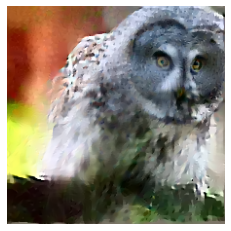

In [9]:
user.plot(reconstructed_user_data)

Notes:
   * Arguably a very good looking owl, even if the metrics do not reflect this well.
   * The color pattern in the background arises from the deep inversion prior.